In [1]:
#%pip install talipp

In [2]:
import os
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib
from sklearn.preprocessing import MinMaxScaler
import requests
from requests_html import HTMLSession
from sklearn.model_selection import train_test_split
import pywt
from talipp.indicators import BOP
from talipp.ohlcv import OHLCVFactory

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [4]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2

In [5]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers=ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [6]:
def calculate_percentage_increase(final_value, starting_value):
    return 100 * ((final_value - starting_value) / starting_value)

In [7]:
def ssl_indicator(df):
    sma_high = talib.SMA(df['high'], 10)
    sma_low = talib.SMA(df['low'], 10)
    hlv = [np.nan]
    for i in range(0, len(df['close'])):
        if df['close'][i] > sma_high[i]:
            hlv.append(1)
        elif df['close'][i] < sma_low[i]:
            hlv.append(-1)
        else:
            hlv.append(hlv[i-1])

    ssl_down = [sma_high[i] if hlv[i] < 0 else sma_low[i] for i in range(len(df.close))]
    ssl_up = [sma_low[i] if hlv[i] < 0 else sma_high[i] for i in range(len(df.close))]

    signals = []
    for i in range(0, len(df.close)):
        if ssl_up[i-1] < ssl_down[i-1] and ssl_up[i] > ssl_down[i]:
            signals.append(Positions.LONG)
        elif ssl_up[i-1] > ssl_down[i-1] and ssl_up[i] < ssl_down[i]:
            signals.append(Positions.SHORT)
        else:
            signals.append(Positions.HOLD)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [8]:
def bbands_indicator(df):
    upper_bband_indicator, _, lower_bband_indicator = talib.BBANDS(df["close"], timeperiod=20)

    signals = []
    for i in range(0, len(df.close)):
        if upper_bband_indicator[i] < df['close'][i]:
            signals.append(Positions.SHORT)
        elif lower_bband_indicator[i] > df['close'][i]:
            signals.append(Positions.LONG)
        else:
            signals.append(Positions.HOLD)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [9]:
def wavetrend_indicator(df):
    ap = (df['high'] + df['low'] + df['close']) / 3
    esa = talib.EMA(ap, 10)
    d = talib.EMA(np.abs(ap - esa), 10)
    ci = (ap - esa) / (0.015 * d)
    tci = talib.EMA(ci, 21)

    signals = []
    for i in range(0, len(tci)):
        if tci[i] > 60:
            signals.append(Positions.SHORT)
        elif tci[i] < -60:
            signals.append(Positions.LONG)
        else:
            signals.append(Positions.HOLD)
        
    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [10]:
def supertrend_indicator(df, atr_period, multiplier):
    
    high = df['high']
    low = df['low']
    close = df['close']
    
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    hl2 = (high + low) / 2
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        else:
            supertrend[curr] = supertrend[prev]

            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return final_lowerband, final_upperband

In [11]:
def rsi_indicator(df):
    rsi = talib.RSI(df.close, 14)

    signals = []
    for i in range(0, len(rsi)):
        if rsi[i] > 70:
            signals.append(Positions.SHORT)
        elif rsi[i] < 30:
            signals.append(Positions.LONG)
        else:
            signals.append(Positions.HOLD)
        
    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [12]:
def produce_prediction(df, window):  
    prediction = (df.shift(window)['close'] <= df['close'])
    
    return prediction.astype(int)

In [13]:
def preprocess_data(df):
    scaler = MinMaxScaler()
    
    mfi_indicator = talib.MFI(df['high'], df['low'], df['close'], df['volume'])
    all_ssl_signals, _, _ = ssl_indicator(df=df)
    all_bbands_signals, _, _ = bbands_indicator(df=df)
    close_b = produce_prediction(df, 1)
    wavetrend_signals, _, _ = wavetrend_indicator(df)
    rsi_signals, _, _ = rsi_indicator(df)

    final_lowerband, final_upperband = supertrend_indicator(df, 10, 3)
    fu_modified = [Positions.LONG if not np.isnan(lowerband) else Positions.HOLD for lowerband in final_lowerband]
    fl_modified = [Positions.SHORT if not np.isnan(upperband) else Positions.HOLD for upperband in final_upperband]
    final_supertrend_indicator = np.sum([fu_modified, fl_modified], axis=0)

    df['close_binary'] = close_b
    df['price_change_percentage'] = calculate_percentage_increase(df['close'], df['close'].shift())
    #df['fpcp'] = df['price_change_percentage'].shift(-1)
    #df['future_price_binary'] = produce_prediction(df, -1)
    df['mfi'] = mfi_indicator
    df['ssl_markover'] = all_ssl_signals
    df['bbands'] = all_bbands_signals
    df['wavetrend_signals'] = wavetrend_signals
    df['supertrend'] = final_supertrend_indicator
    df['rsi_signals'] = rsi_signals
    df = df.drop(columns={"volume", "Adj Close", "open", "high", "low", "date"})
    df = df.dropna()
    
    df[['mfi', 'price_change_percentage']] = scaler.fit_transform(df[['mfi','price_change_percentage']])
    
    return df

In [14]:
#df = getTickerData('btc-usd', '730d', '1h')
#df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})

In [15]:
session = HTMLSession()
num_currencies=23
symbols_to_remove = ['USDT-USD', 'USDC-USD', 'XRP-USD', 'BUSD-USD', 'DAI-USD', 'SHIB-USD']
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
symbols_yf = df.Symbol.tolist()
for symbol in symbols_to_remove:
    symbols_yf.remove(symbol)
print(symbols_yf)

['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'STETH-USD', 'DOGE-USD', 'MATIC-USD', 'SOL-USD', 'WTRX-USD', 'TRX-USD', 'LTC-USD', 'DOT-USD', 'AVAX-USD', 'WBTC-USD', 'ATOM-USD', 'LINK-USD', 'LEO-USD']


In [16]:
dataframes = []

for symbol in symbols_yf:
    df = getTickerData(symbol, '730d', '1h')
    df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
    dataframes.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [17]:
preprocessed_dataframes = []
for df in dataframes:
    p_df = preprocess_data(df)
    if p_df.shape[1] == 9:
        preprocessed_dataframes.append(preprocess_data(df))

In [142]:
training_data = []
testing_data = []
for df in preprocessed_dataframes:
    train, test = train_test_split(df, train_size=0.8, shuffle=False)
    training_data.append(train.dropna())
    testing_data.append(test.dropna())

In [143]:
amount_of_rows = 0
for df in training_data:
    print(df.shape)
    amount_of_rows += df.shape[0]
print(f'total rows of training data - {amount_of_rows}')

(13800, 9)
(13800, 9)
(13804, 9)
(13800, 9)
(9066, 9)
(13802, 9)
(13806, 9)
(10082, 9)
(8588, 9)
(13800, 9)
(13802, 9)
(10082, 9)
(13802, 9)
(9126, 9)
(10082, 9)
(13801, 9)
(9126, 9)
total rows of training data - 204169


In [144]:
training_data[0]

,close,close_binary,price_change_percentage,mfi,ssl_markover,bbands,wavetrend_signals,supertrend,rsi_signals
14,36603.707031,0,0.451844,1.000000,1,2,2,3,2
15,36254.527344,0,0.459602,1.000000,0,2,2,3,2
16,35914.058594,0,0.460758,1.000000,2,2,2,3,2
17,36184.167969,1,0.592506,1.000000,2,2,2,3,2
18,36277.851562,1,0.554086,1.000000,2,2,2,3,2
...,...,...,...,...,...,...,...,...,...
13809,16870.269531,0,0.533442,0.980544,2,2,2,3,0
13810,16869.171875,0,0.533409,0.887242,2,2,2,3,0
13811,16847.531250,0,0.523923,0.879935,2,2,2,3,2
13812,16845.255859,0,0.532864,0.858967,2,2,2,3,2


In [152]:
dj = getTickerData('HEX-USD', '730d', '1h')
dj = dj.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
dc = preprocess_data(dj)
dc

[*********************100%***********************]  1 of 1 completed


,close,close_binary,price_change_percentage,mfi,ssl_markover,bbands,wavetrend_signals,supertrend,rsi_signals
14,0.051109,1,0.403047,0.427097,2,2,2,3,2
15,0.052235,1,0.424557,0.427097,2,2,2,3,2
16,0.052005,0,0.396313,0.427097,2,2,2,3,2
17,0.052875,1,0.418904,0.315857,2,2,2,3,2
18,0.052525,0,0.393923,0.456145,1,2,2,3,2
...,...,...,...,...,...,...,...,...,...
17267,0.013057,1,0.446704,0.498407,2,0,2,2,2
17268,0.013101,1,0.404634,0.506559,2,2,2,2,2
17269,0.012989,0,0.391860,0.520257,2,2,2,2,2
17270,0.012701,0,0.377254,0.553026,2,2,2,2,2


In [153]:
#pcp = training_data[10][['price_change_percentage']]
pcp = dc[['price_change_percentage']]

17258
(17258, 1)


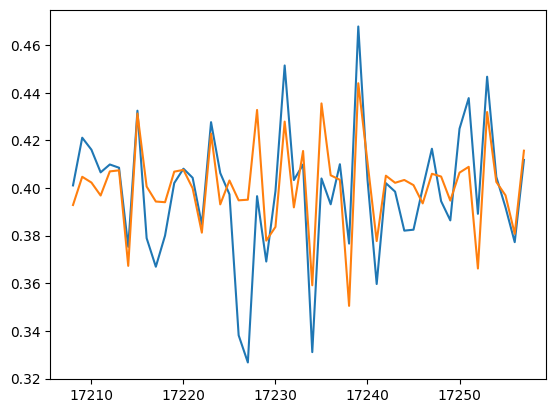

In [155]:
coeffs = pywt.wavedec(pcp['price_change_percentage'].to_numpy(), 'sym5', mode='symmetric')
for i in range(5):
    coeffs[i+5] = np.zeros(coeffs[i+5].shape)
y_rec = pywt.waverec(coeffs, 'sym5', mode='symmetric')
n = 50
print(len(y_rec))
print(pcp.shape)
plt.plot(range(pcp.shape[0]-n, pcp.shape[0]),pcp[-n:])
plt.plot(range(len(y_rec)-n, len(y_rec)),y_rec[-n:])

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose

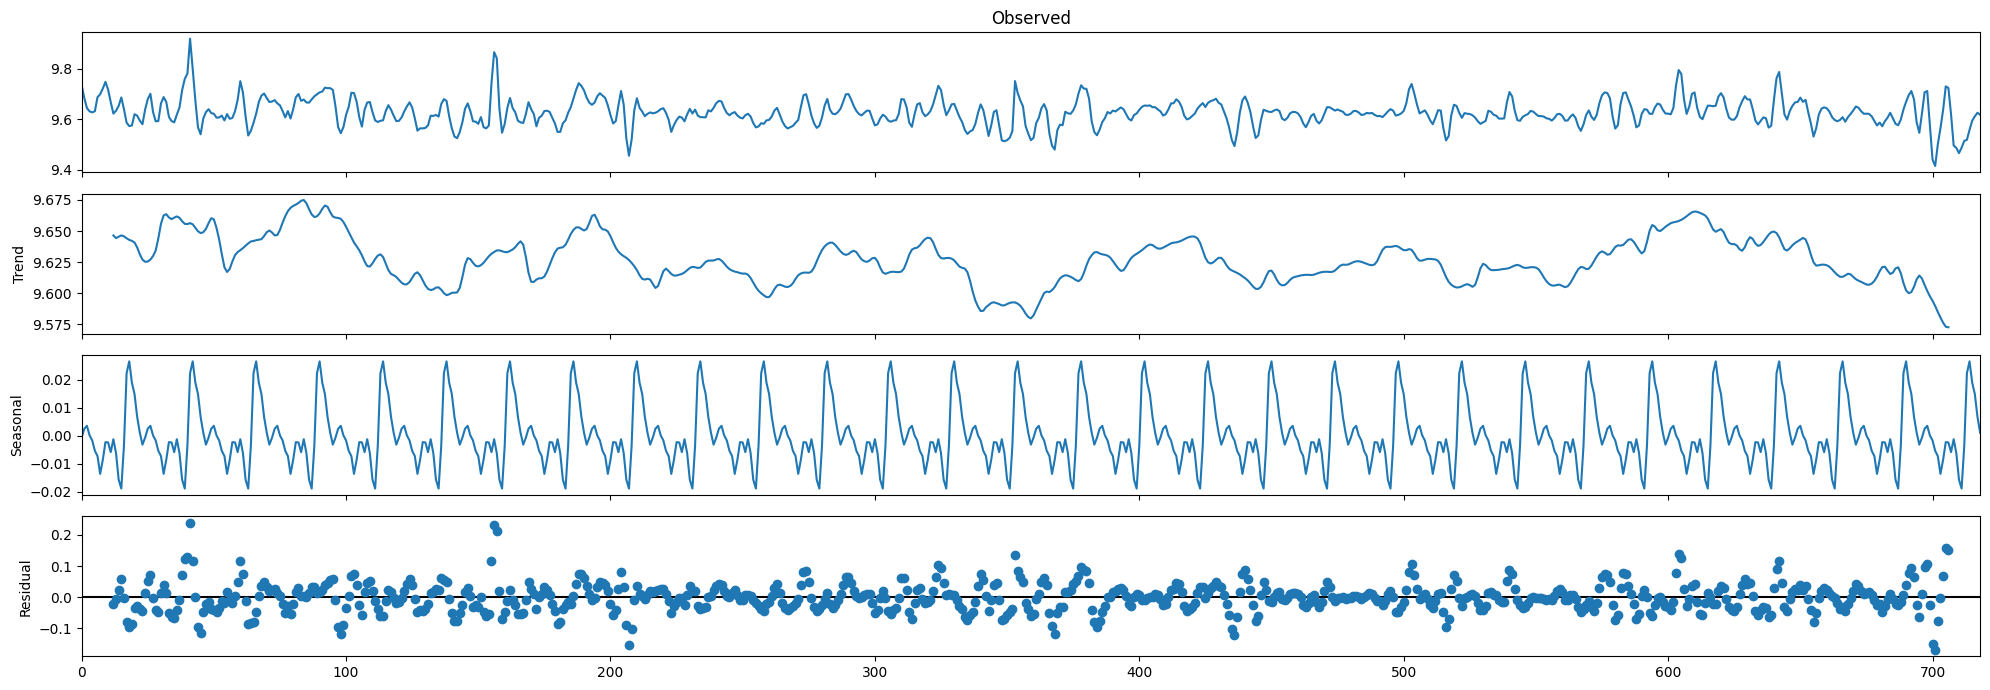

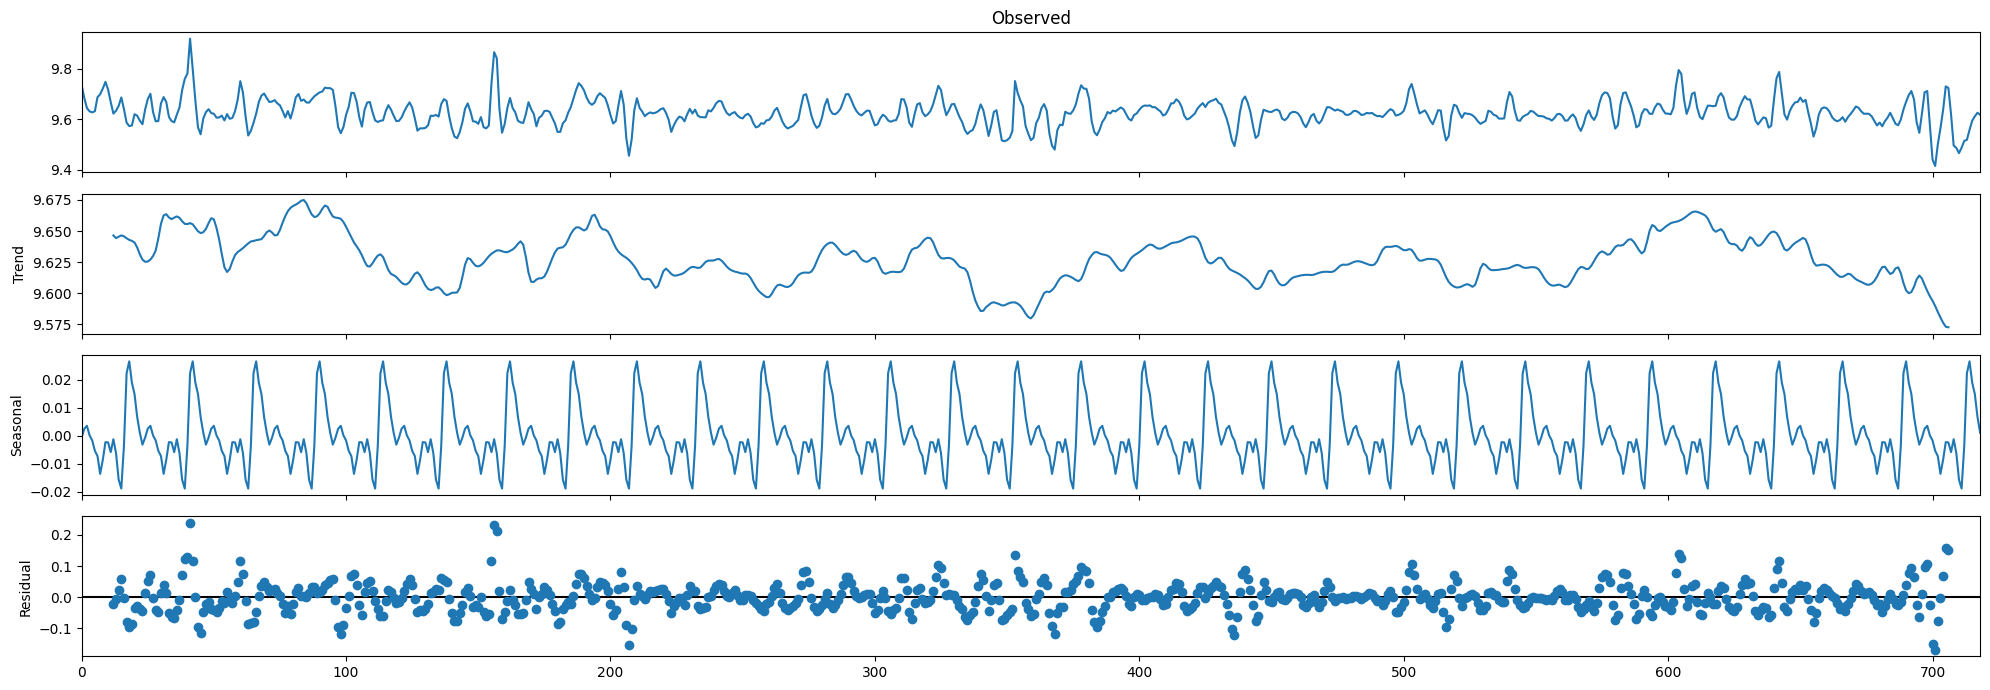

In [220]:
def sum_close(y, v):
    g = 1
    value = 0
    values = []
    v = v
    for i, row in enumerate(y):
        if g == v:
            value+=row
            values.append(value)
            value = 0
            g=1
        else:
            value+=row
            g+=1
    
    return values

v = 24
values = sum_close(y_rec, v)
d = seasonal_decompose(values, period=v)
d.plot()

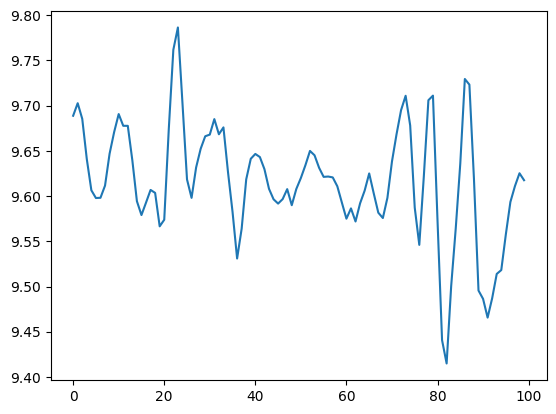

In [221]:
plt.plot(values[-100:])
#plt.plot(range(0, 100), dc[-100:]['price_change_percentage'])

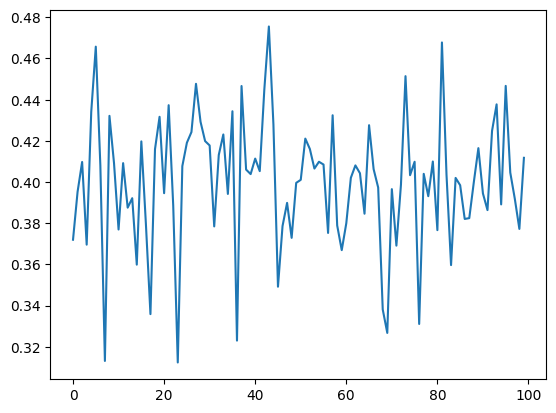

In [222]:
plt.plot(range(0, 100), dc[-100:]['price_change_percentage'])

In [70]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [71]:
n_input = 13
n_featues = 1
generator = TimeseriesGenerator(values, values, length=n_input, batch_size=2048)

In [72]:
x, y = generator[0]
print(x.flatten())
print(y)

[0.58172252 0.55982713 0.52904108 ... 0.59591191 0.56157373 0.52127595]
[0.63841431 0.57113875 0.54592508 ... 0.56157373 0.52127595 0.61329132]


In [46]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

In [73]:
optimizer = Adam()

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_featues)))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.fit(generator, epochs=130)

Epoch 1/130
2/2 [==============================] - 1s 420ms/step - loss: 0.3934
Epoch 2/130
2/2 [==============================] - 1s 196ms/step - loss: 0.3189
Epoch 3/130
2/2 [==============================] - 1s 359ms/step - loss: 0.2315
Epoch 4/130
2/2 [==============================] - 1s 219ms/step - loss: 0.1729
Epoch 5/130
2/2 [==============================] - 1s 196ms/step - loss: 0.1070
Epoch 6/130
2/2 [==============================] - 1s 192ms/step - loss: 0.0442
Epoch 7/130
2/2 [==============================] - 1s 344ms/step - loss: 0.0081
Epoch 8/130
2/2 [==============================] - 1s 196ms/step - loss: 0.0407
Epoch 9/130
2/2 [==============================] - 1s 357ms/step - loss: 0.0295
Epoch 10/130
2/2 [==============================] - 1s 216ms/step - loss: 0.0087
Epoch 11/130
2/2 [==============================] - 1s 200ms/step - loss: 0.0048
Epoch 12/130
2/2 [==============================] - 1s 270ms/step - loss: 0.0106
Epoch 13/130
2/2 [===================

KeyboardInterrupt: 

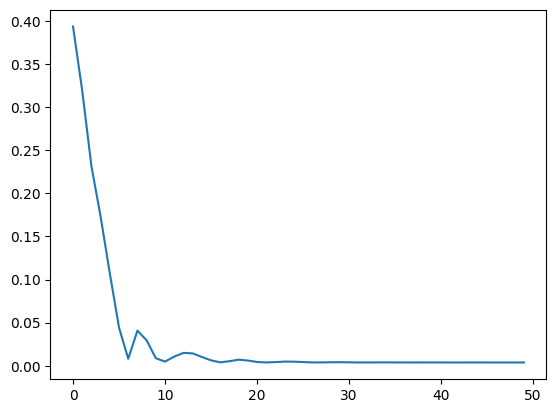

In [75]:
loss_history = model.history.history['loss']
plt.plot(range(len(loss_history)), loss_history)

In [217]:
predictions = []
true_values = []
print(len(values))

dic = {'price_change_percentage': values}
daf = pd.DataFrame.from_dict(dic)

episodes = 100

r = random.randint(0, daf.shape[0])
while r - episodes > episodes:
    r = random.randint(0, daf.shape[0])
    
data = daf.iloc[r:]['price_change_percentage']

for i in range(0, episodes):
    e = data.iloc[i:n_input+i].to_numpy().reshape((1, n_input, n_featues))
    pred = model.predict(e, verbose=0)[0]
    
    predictions.append(pred)
    true_values.append(data.iloc[n_input+ i+1])    

719


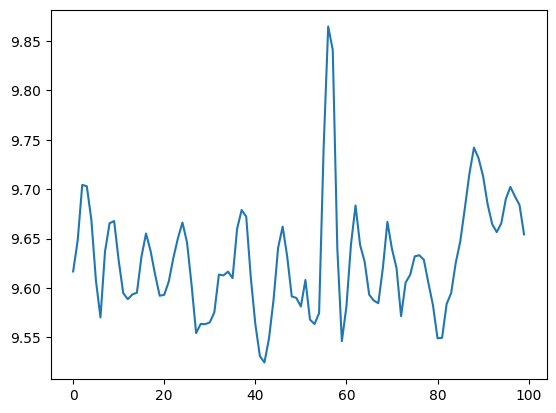

In [218]:
jik = sum_close(pcp['price_change_percentage'].to_numpy(), 24)
#plt.plot(jik[r:r+episodes])
plt.plot(values[r:r+episodes])

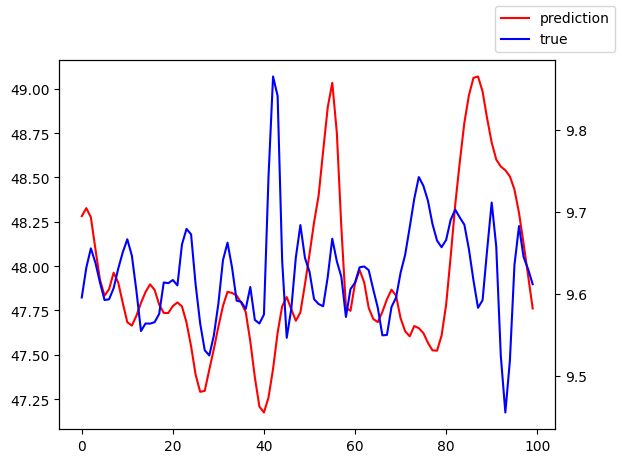

In [219]:
fig, ax_left = plt.subplots()
ax_left.plot(range(len(predictions)), predictions, label='prediction', color='r')
ax_right = ax_left.twinx()
ax_right.plot(range(len(true_values)), true_values, label='true', color='b')
fig.legend()

In [213]:
rat = 0
rat_2 = 0
true = []
pred = []
f = 0

for i in range(0, len(predictions)):
    if true_values[i] > rat:
        true.append(1)
    else:
        true.append(-1)
    if predictions[i] > rat_2:
        pred.append(1)
    else:
        pred.append(-1)
    rat = true_values[i]
    rat_2 = predictions[i]

for i in range(0, len(pred)):
    if pred[i] == true[i]:
        f+=1
        
print('Accuracy:', f/len(pred)) 

Accuracy: 0.43


In [260]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()        
        self.df = df
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df[0].shape[1]-1), dtype=np.float64)
        self.action_space = Discrete(len(Positions))
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.needed_space = self.window_size + self.n_steps
        self.random_df = random.randint(0, len(self.df) - 1)
        self.random_index = random.randint(0, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        #self.last_binary_indicators = self.df[self.random_df].drop(columns={'close', 'mfi', 'price_change_percentage', 'close_binary'}).iloc[self.random_index+self.window_size+self.current_step-1].values
        
        self.positions = []
        self.current_pos = None
        self.held_price = 0
        self.in_a_pos = False
        
        self.trading_positions = 0
        self.profited_trading_positions = 0
        
        self.portfolio = 1
        
    def step(self, action):
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        #self.last_binary_indicators = self.df[self.random_df].drop(columns={'close', 'mfi', 'price_change_percentage', 'close_binary'}).iloc[self.random_index+self.window_size+self.current_step-1].values
        reward, p, t, i = self.calculate_reward(action)
            
        if action != Positions.HOLD:
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
            
        self.positions.append(action)
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
            
        observation = self.get_observation()
        info = {'p': p, 't': t, 'i': i}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_df = random.randint(0, len(self.df) - 1)
        self.random_index = random.randint(0, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        self.done = False
        self.current_step = 0
        self.positions.clear()
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        #self.last_binary_indicators = self.df[self.random_df].drop(columns={'close', 'mfi', 'price_change_percentage', 'close_binary'}).iloc[self.random_index+self.window_size+self.current_step-1].values
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        self.trading_positions = 0
        self.profited_trading_positions = 0
        self.portfolio = 1
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_df = random.randint(0, len(self.df) - 1)
            self.random_index = random.randint(0, self.df[self.random_df].value_counts().sum() - self.needed_space-1)
        return self.df[self.random_df].iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].drop('close', axis=1).values
    
    def final_render(self):
        final_observation = self.df[self.random_df].iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['close']
        
        #winrate = round(self.profited_trading_positions / self.trading_positions, 5)
            
        buy_signal = [True if self.positions[n]==Positions.LONG else False for n in range(0, len(self.positions))]
        sell_signal = [True if self.positions[n]==Positions.SHORT else False for n in range(0, len(self.positions))]
        hold_signal = [True if self.positions[n]==Positions.HOLD else False for n in range(0, len(self.positions))]
        buy_signal.append(False)
        sell_signal.append(False)
        hold_signal.append(False)
        
        plt.figure(figsize=(30,10))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = buy_signal)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = sell_signal)
        plt.plot(final_observation, 'o', markersize=6, color='b', label = 'Holding signal', markevery = hold_signal)
        plt.xticks([])
        plt.title("Final result of the last trading session")
        plt.ylabel('Close price')
        plt.legend()
        plt.show()
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [261]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
        
    def calculate_reward(self, action):
        reward = 0
        percentage = 0.
        total_profit = 0
        amount_to_use = 0.05
        #indicator_monitor_reward = 0.01 * ((self.last_binary_indicators == action).sum())
        #reward = indicator_monitor_reward

        if self.in_a_pos and action != Positions.HOLD:
            percentage = calculate_percentage_increase(self.final_value, self.held_price)
            if self.current_pos == Positions.SHORT:
                percentage = -percentage
                
            total_profit += ((self.portfolio * amount_to_use) * percentage)
            portfolio_change = self.portfolio + ((self.portfolio * amount_to_use) * percentage)
            self.portfolio = portfolio_change
            
            self.trading_positions+=1
            if reward > 0:
                self.profited_trading_positions+=1
            
            reward = total_profit
            
            if reward < 0:
                reward *= 1
            
        return reward, percentage, total_profit, 0

In [262]:
env = Trading(training_data, window_size=14, n_steps=200)
env = Monitor(env)
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


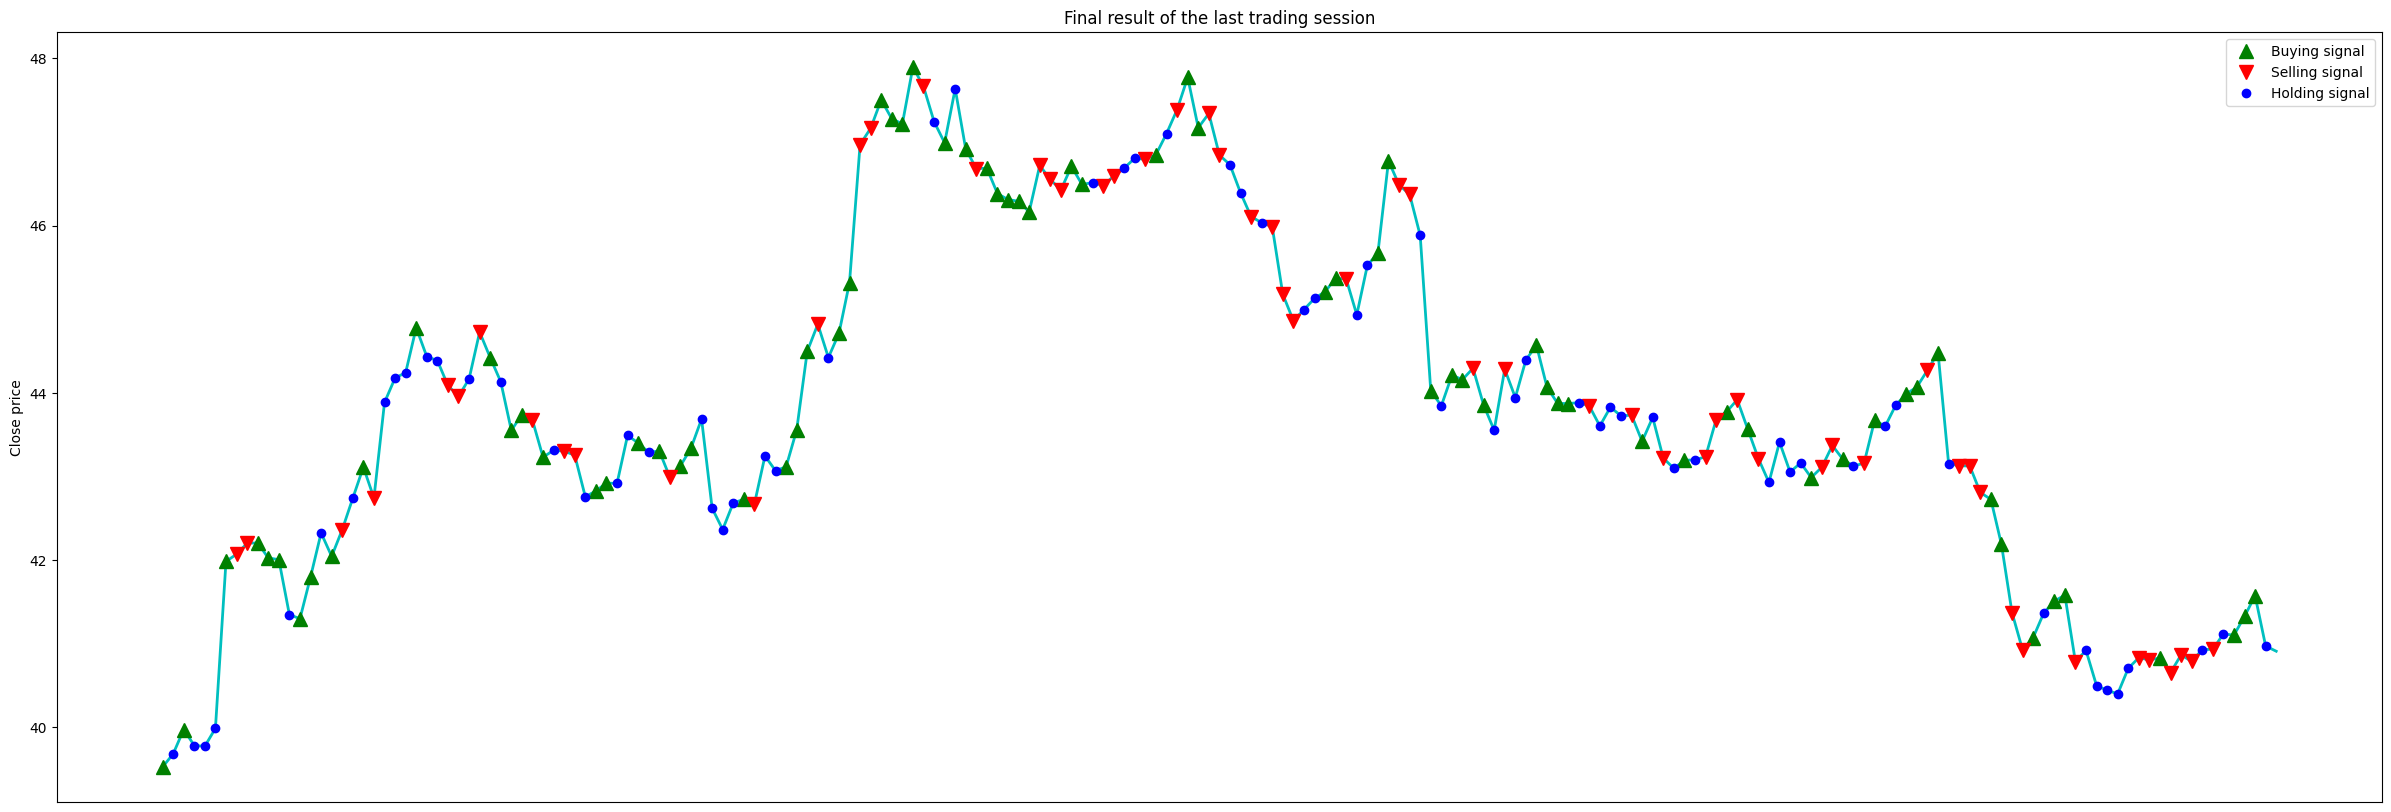

episode - 1 || score - 0.22106821031937762
None
0.22106821031937762


In [263]:
episodes = 1
for n in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    ss = 0
    total_profit_ = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        #print("REWARD", reward)
        #print('TOTAL_PROFIT', info['t'])
        #print('PERCENTAGE', info['p'])
        #print('INDICATOR_REWARD', info['i'])
        total_profit_ += info["t"]
    winrate = env.final_render()
    print(f"episode - {n} || score - {score}")
    print(winrate)
    print(total_profit_)

In [264]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"
OPT_DIR = "./opt/"

In [265]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [223]:
def optimize_ppo(trial):
    return {
        "n_steps": trial.suggest_int("n_steps", 64, 8192),
        "gamma": trial.suggest_loguniform("gamma", 0.8, 0.9999),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
        "clip_range": trial.suggest_uniform("clip_range", 0.1, 0.4),
        "gae_lambda": trial.suggest_uniform("gae_lambda", 0.8, 0.99),
        "ent_coef": trial.suggest_uniform("ent_coef", 0.001, 0.01),
    }

In [224]:
def optimize_agent(trial):
    try:
        model_params=optimize_ppo(trial)
        env = Trading(df, window_size=90, n_steps=100)
        
        model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, **model_params)
        model.learn(100000)
        
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        
        return mean_reward
    except Exception as e:
        return -1000

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_agent, n_trials=35, n_jobs=1)

In [ ]:
study.best_params

{'n_steps': 7917,
 'gamma': 0.8148319613766952,
 'learning_rate': 1.1494222672968137e-05,
 'clip_range': 0.11454224768088915,
 'gae_lambda': 0.9747187305774679,
 'ent_coef': 0.007806731954039324}

In [266]:
model = RecurrentPPO(
    "MlpLstmPolicy",
    env,
    verbose=0,
    tensorboard_log=LOG_DIR,
    n_steps=7917,
    gamma=0.8148319613766952,
    learning_rate=1.1494222672968137e-05,
    clip_range=0.11454224768088915,
    gae_lambda=0.9747187305774679,
    ent_coef=0.007806731954039324,
)

In [83]:
loaded_model = RecurrentPPO.load("./train/best_model_300000", env=env)

In [ ]:
opt_model = RecurrentPPO.load("./saved_models/opt_model_training_1", env=env)

In [289]:
training_data[0]

,close,close_binary,price_change_percentage,fpcp,mfi
14,36646.554688,0,0.451314,0.561570,0.609722
15,36776.640625,1,0.561570,0.346771,0.606692
16,35893.144531,0,0.346771,0.547079,0.606692
17,35953.789062,1,0.547079,0.603118,0.543178
18,36273.171875,1,0.603118,0.444155,0.571378
...,...,...,...,...,...
13805,16567.683594,1,0.542143,0.531951,0.674443
13806,16563.503906,0,0.531951,0.528143,0.655199
13807,16551.228516,0,0.528143,0.540880,0.655199
13808,16566.023438,1,0.540880,0.537171,0.655199


In [287]:
model.learn(total_timesteps=200000, callback=callback)

In [60]:
evaluate_policy(model, env, n_eval_episodes=10)

(8.265, 0.3259831283977746)

In [88]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

(0.0, 0.0)

In [72]:
evaluate_policy(opt_model, env, n_eval_episodes=10)

NameError: name 'opt_model' is not defined

In [268]:
def test_portfolio(model, starting_money, amount_to_use, total_episodes_to_run = 1):
    all_portfolio_accumulation_results = []
    all_final_portfolio_value = []
    all_score = []
    win = 0
    
    for episode in range(1, total_episodes_to_run+1):
        obs = env.reset()
        done = False
        score = 0
        portfolio = starting_money
        portfolio_accumulation_results = []
        percentage_increase = 0
        total_profit = 0
    
        while not done:
            action, lstm_cells = model.predict(obs)
            obs, reward, done, info = env.step(action)
            score += reward
            percentage_increase = info['p']
        
            total_profit += ((starting_money * amount_to_use) * percentage_increase)
            portfolio_change = portfolio + ((starting_money * amount_to_use) * percentage_increase)
            portfolio = portfolio_change
            portfolio_accumulation_results.append(portfolio_change)
        
        all_portfolio_accumulation_results.append(portfolio_accumulation_results)
        all_final_portfolio_value.append(portfolio)
        all_score.append(score)
        if total_profit > 0:
            win += 1
        
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 7)
    for i in range(0, len(all_portfolio_accumulation_results)):
        ax.plot(all_portfolio_accumulation_results[i])
    env.final_render()
    
    print(f'avg score - {np.average(all_score)}')
    print(f'avg final portfolio value - {np.average(all_final_portfolio_value)}')
    print(f'winrate - {win / total_episodes_to_run}')

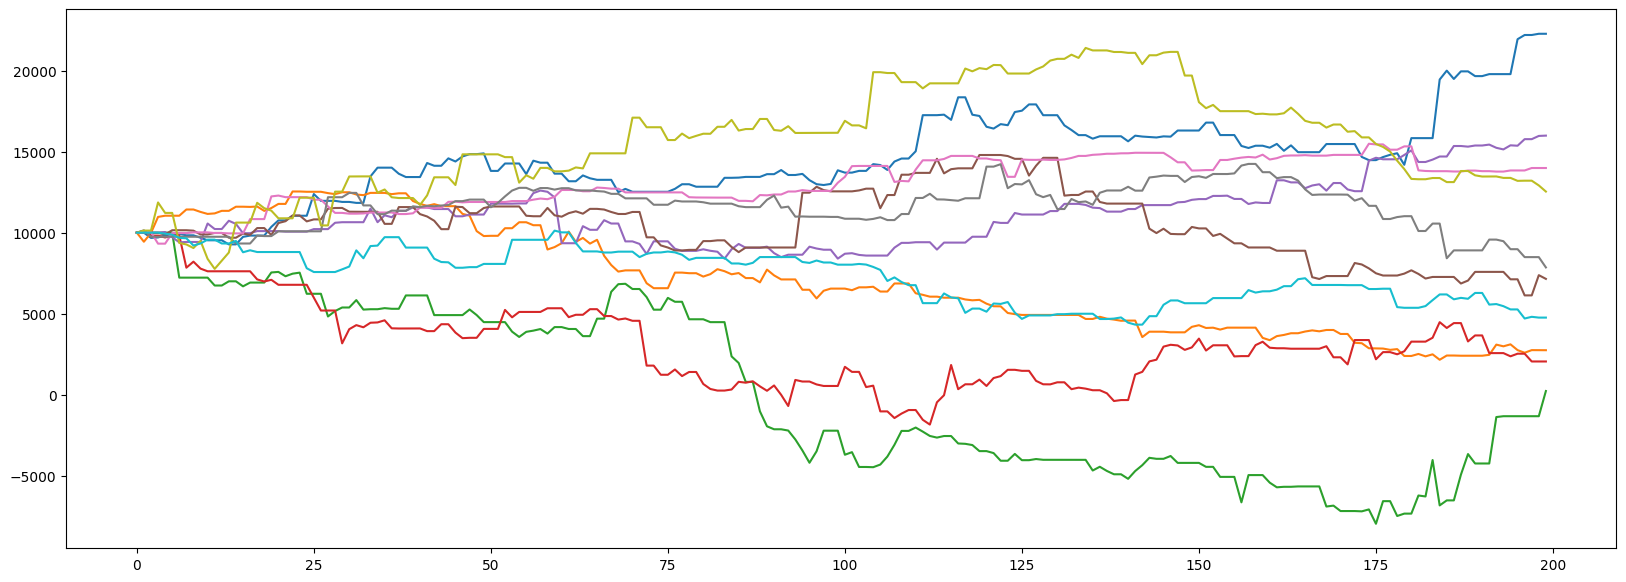

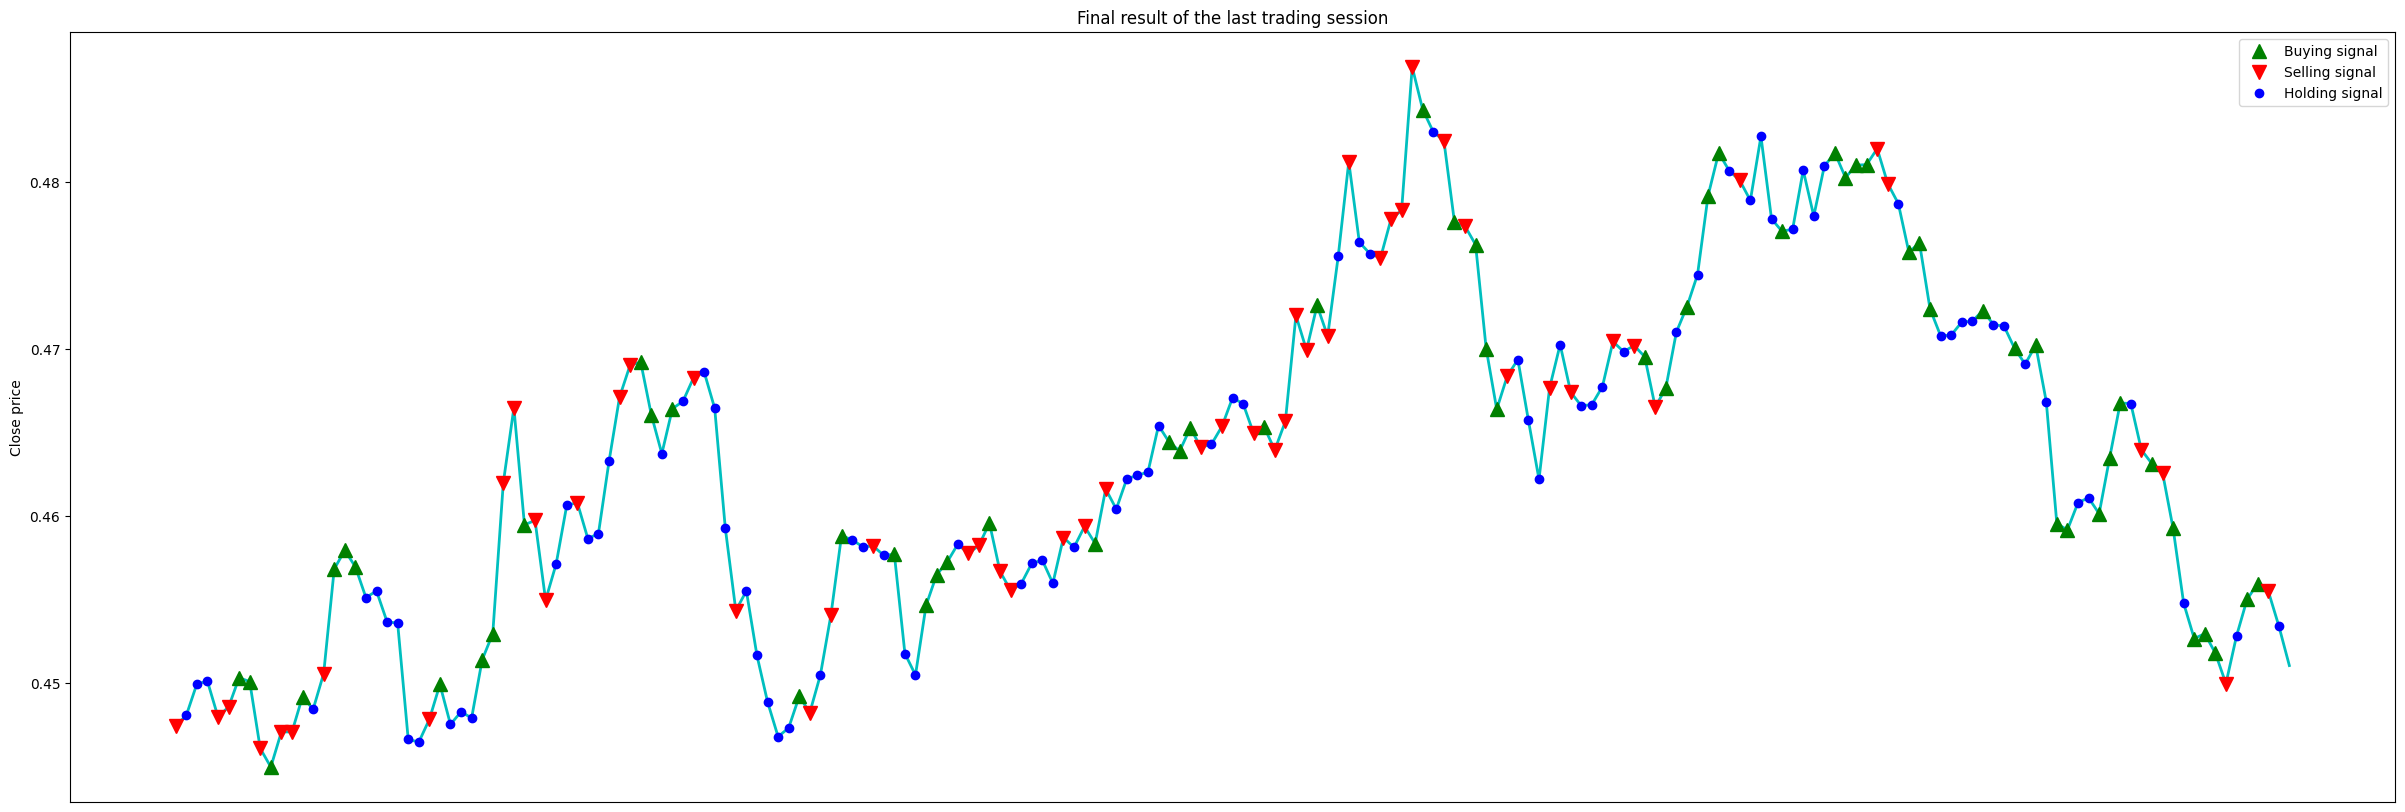

avg score - -0.05382053014680048
avg final portfolio value - 8958.240048221767
winrate - 0.4


In [269]:
test_portfolio(model, starting_money=10000, amount_to_use=0.05, total_episodes_to_run=10)